#  Novelty Detection (Semi-Supervised)

##  Imports

In [60]:
%load_ext autoreload
%autoreload 

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.set()

# Data pre-processing
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

# Dimensionality reduction
from MulticoreTSNE import MulticoreTSNE as TSNE # https://github.com/DmitryUlyanov/Multicore-TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Anomaly detection models from sklearn
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Anomaly detection models from pyod
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, recall_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# run some files containing custom functions
%run -i '../scripts/anomaly_helper_functions.py'
%run -i '../scripts/helper_functions.py'

## Load data

In [3]:
#  Load cleaned data
df = pd.read_csv('../raw_data/clean_data.csv')
df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,FATAL,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,C_CASE
0,1999,January,Monday,9.0,0,2.0,Right turn,At an intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1992.0,1.0,F,33.0,Driver,Injury,Safety device used,Motor Vehicle Driver,2890
1,1999,January,Monday,9.0,0,2.0,Right turn,At an intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1992.0,1.0,F,70.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,2890
2,1999,January,Monday,20.0,0,1.0,Ran off left shoulder,Intersection with parking lot entrance,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1988.0,1.0,F,38.0,Driver,Injury,Safety device used,Motor Vehicle Driver,4332
3,1999,January,Monday,5.0,0,2.0,Hit a moving object,At an intersection,Raining,Wet,...,Other trucks and vans,1995.0,1.0,M,34.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,5053
4,1999,January,Monday,5.0,0,2.0,Hit a moving object,At an intersection,Raining,Wet,...,Other trucks and vans,1995.0,2.0,M,30.0,"Front row, right outboard",No Injury,Safety device used,Motor Vehicle Passenger,5053


In [4]:
df.shape

(3817613, 23)

In [5]:
# Shuffle the dataset
df = df.sample(frac =1).reset_index(drop = True)

## Class distribution

0    98.39
1     1.61
Name: FATAL, dtype: float64

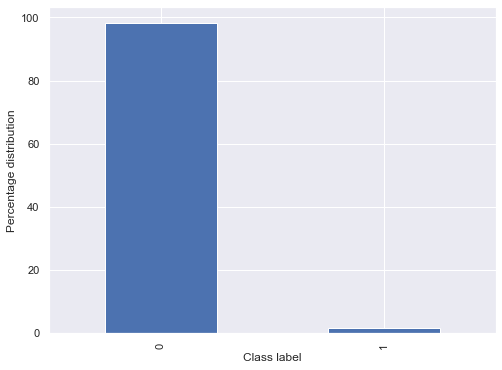

In [6]:
class_dis = (df.FATAL.value_counts()/len(df)*100)
class_dis.plot(kind = 'bar', figsize = (8,6))
plt.xlabel('Class label')
plt.ylabel('Percentage distribution')
round(class_dis,2)

## Reduce the Dataset

Since the dataset is very large to fit in a small laptop memory, training the entire dataset on a laptop will take days to run let alone tuning the hyperparameters by grid search.  Hence, we will first split the dataset into two subsets and train the model on the small subset

In [7]:
X1, X2, y1, y2 = train_test_split(df,df.FATAL, test_size = 0.01, random_state = 42, stratify = df.FATAL)

In [8]:
print('Large subset size:', X1.shape, y1.shape)
print('Small subset size:', X2.shape, y2.shape)

Large subset size: (3779436, 23) (3779436,)
Small subset size: (38177, 23) (38177,)


In [9]:
# Save the small subset as csv file
X2.to_csv('../data/collision.csv', index = False)

#  Anomaly Detection Models 

In [10]:
# Reload data
df_small = pd.read_csv('../data/collision.csv')

In [11]:
# Feature matrix and class label
X, y = df_small.drop(['P_ID', 'V_ID', 'FATAL'], axis = 1), df_small['FATAL']
print('Data size:', X.shape, y.shape)

Data size: (38177, 20) (38177,)


## 1. Create a Test Set

We now split the into $80\%$ training set and $20\%$ test set in a stratify fashion

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [50]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (30541, 20) (30541,)
Test set size: (7636, 20) (7636,)


In [51]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('*********************************')
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    98.395599
1     1.604401
Name: FATAL, dtype: float64
*********************************
Test set class distribution:
 0    98.389209
1     1.610791
Name: FATAL, dtype: float64


##  2. Data Pre-processing

In [52]:
# List of categorical attributes
cat_subset = list(X_train.select_dtypes('O'))

# List of numerical attributes
num_subset = list(X_train.select_dtypes('number'))

# Binarize the categorical attributes
cat_attribs = [([cat], LabelBinarizer()) for cat in cat_subset]

# Standardize the numerical attributes
num_attribs = [([num], StandardScaler()) for num in num_subset]

# Build a dataframe mapper pipeline
mapper = DataFrameMapper(cat_attribs + num_attribs)

# Fit transform the training set
X_train_scaled = mapper.fit_transform(X_train)

# Only transform the training set
X_test_scaled = mapper.transform(X_test)

In [53]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (30541, 130)
Test set size after pre-processing: (7636, 130)


## 3. Dimensionality Reduction

In [78]:
# PCA
pca = PCA(n_components = 120)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [79]:
# Size of the data after PCA
print('Training set size after PCA:', X_train_pca.shape)
print('Test set size after PCA:', X_test_pca.shape)

Training set size after PCA: (30541, 120)
Test set size after PCA: (7636, 120)


In [56]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# Models

## 1. Isolation Forest

In [81]:
# train IForest detector
clf_name = 'IForest'
clf = IForest()
clf.fit(X_train_pca)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test_pca)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test_pca)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evalaute_performance(y_train, y_train_pred)

print("\nOn Test Data:")
evalaute_performance(y_test, y_test_pred)


On Training Data:
Accuracy:  0.897711
AUROC: 0.666966
AUPRC: 0.038638
Confusion matrix:
 [[27207  2844]
 [  280   210]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     30051
           1       0.07      0.43      0.12       490

    accuracy                           0.90     30541
   macro avg       0.53      0.67      0.53     30541
weighted avg       0.98      0.90      0.93     30541

*****************************************************************************

On Test Data:
Accuracy:  0.902829
AUROC: 0.682720
AUPRC: 0.043652
Confusion matrix:
 [[6838  675]
 [  67   56]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      7513
           1       0.08      0.46      0.13       123

    accuracy                           0.90      7636
   macro avg       0.53      0.68      0.54      7636
weighted avg       0.98      0.90      0.